### Basic Imports 

In [3]:
pip install "git+https://github.com/Sh1vam/nlp_lib.git"

  Cloning https://github.com/Sh1vam/nlp_lib.git to /tmp/pip-req-build-jfwl9fwe
  Running command git clone --filter=blob:none --quiet https://github.com/Sh1vam/nlp_lib.git /tmp/pip-req-build-jfwl9fwe
  fatal: unable to access 'https://github.com/Sh1vam/nlp_lib.git/': Could not resolve host: github.com
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/Sh1vam/nlp_lib.git /tmp/pip-req-build-jfwl9fwe did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/Sh1vam/nlp_lib.git /tmp/pip-req-build-jfwl9fwe did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nltk
nltk.download('''wordnet''')

nltk.download('''stopwords''')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
from nlp_lib import *
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import joblib
import yaml
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input,GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import chain
import random
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'nlp_lib'

### Basic Text Cleaning & Data Pre-processing

In [ ]:
stopwords = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
df=pd.read_csv("/kaggle/input/solarsystem-question-answers/myds.csv")
df.drop(columns="Intent",inplace=True)
df['Question']=df['Question'].str.lower()
df['Answer']=df['Answer'].str.lower()
df['Question']=df['Question'].apply(removes_non_printables)

### Data Augmentation 

In [ ]:
# Define a basic synonym replacement function with built-in methods
def basic_synonym_replacement(sentence, limit=100):
    tokens = sentence.split()  # Use basic split to tokenize
    augmented_sentences = []

    # A simple manual synonym dictionary as a placeholder for WordNet
    synonym_dict = {
        "is": ["exists", "constitutes"],
        "belt": ["region", "area"],
        "largest": ["biggest", "most substantial","huge"],
        "smallest":["small","tiny"],
        "object": ["entity", "thing"],
        "asteroid": ["space rock", "minor planet"],
        "what": ["define what","which"],
        "how many":["what is","what are","how much"],
        "how much":["what is","what are","how many"],
        "what is": ["define","give","what are", "give me","tell about","tell me about"],
        "which":["what"],
        "which is":["what","give","which are", "give me","tell about","tell me about"],
        "exists":["where exists","what exists"],
        "mars":["red planet","redplanet","red-planet"],
        "much":["many"],
        "what is the distance":["how much distance","how much is the distance"],
        "solar system":["solarsystem","solar-system"],
        "solarsystem":["solar system","solar-system"],
        "between":["from"],
        "to":["and"],
        "do":["does"],
        "does":["do"],
        "the":["a","an",""],
        'a':["the","an",""],
        "an":["the","a",""],
        "number":["no"]
    }

    # Iterate through each token in the sentence
    for i, token in enumerate(tokens):
        synonyms = synonym_dict.get(token.lower(), [])  # Get synonyms if available

        if synonyms:
            num_augmentations = min(limit, len(synonyms))
            sampled_synonyms = random.sample(synonyms, num_augmentations)

            # Create new augmented sentences by replacing the word with each synonym
            for synonym in sampled_synonyms:
                augmented_tokens = tokens[:i] + [synonym] + tokens[i+1:]
                augmented_sentences.append(' '.join(augmented_tokens))

    return augmented_sentences

def augment_dataset(df, limit=1111):
    augmented_data = []

    for _, row in df.iterrows():
        question = row['Question']
        answer = row['Answer']

        # Generate augmented sentences for the question
        augmented_sentences = basic_synonym_replacement(question, limit)

        # Store the original question with the corresponding answer
        augmented_data.append([question, answer])  # Original question

        # Store each augmented question with the same original answer
        for augmented_sentence in augmented_sentences:
            augmented_data.append([augmented_sentence, answer])  # Augmented question with original answer

    # Return the augmented data as a DataFrame with both Question and Answer columns
    return pd.DataFrame(augmented_data, columns=['Question', 'Answer'])

# Apply the function to the dataset
augmented_df1 = augment_dataset(df)
#df=pd.concat([df, augmented_df1], ignore_index=True)
df=augmented_df1

In [ ]:
# Synonym replacement function with caching
synonym_cache = {}
# idea from: https://github.com/roshancharlie/College-Chatbot-Using-ML-and-NLP/blob/main/College%20Chatbot.ipynb
def synonym_replacement(tokens, limit=100):
    augmented_sentences = []

    for i in range(len(tokens)):
        token = tokens[i]

        # Check if we've already cached the synonyms for this token
        if token in synonym_cache:
            synonyms = synonym_cache[token]
        else:
            synonyms = set()
            for syn in wordnet.synsets(token):
                for lemma in syn.lemmas():
                    synonym = lemma.name().replace('_', ' ')
                    if synonym != token:
                        synonyms.add(synonym)
            synonyms = list(synonyms)
            synonym_cache[token] = synonyms  # Cache the result

        # If synonyms were found, create augmented sentences
        if synonyms:
            num_augmentations = min(limit, len(synonyms))
            sampled_synonyms = random.sample(synonyms, num_augmentations)
            for synonym in sampled_synonyms:
                augmented_tokens = tokens[:i] + [synonym] + tokens[i+1:]
                augmented_sentences.append(' '.join(augmented_tokens))

    return augmented_sentences

# Define limit for augmentation per tag
limit_per_tag = 1111

# Process each row in the dataset and collect augmented data
text_data = []
answers = []

for _, row in df.iterrows():
    example = row['Question']
    answer = row['Answer']

    # Tokenize and preprocess
    tokens = word_tokenize(example.lower())
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]

    # Only augment if the filtered tokens are valid
    if filtered_tokens:
        # Add the original data
        text_data.append(' '.join(filtered_tokens))
        answers.append(answer)

        # Generate augmented sentences
        augmented_sentences = synonym_replacement(filtered_tokens, limit=limit_per_tag)

        # Limit the number of augmentations per tag
        for idx, augmented_sentence in enumerate(augmented_sentences):
            if idx >= limit_per_tag:
                break
            text_data.append(augmented_sentence)
            answers.append(answer)

# Convert augmented data into a new DataFrame
augmented_df2 = pd.DataFrame({
    'Question': text_data,
    'Answer': answers
})
#df=pd.concat([df, augmented_df2], ignore_index=True)
df = augmented_df2

In [ ]:
df['Question'] = df['Question'].apply(removes_specials).str.lower()

In [ ]:
df.shape

### Storing Processed Data To New CSV File For Future Use

In [ ]:
df.to_csv("/kaggle/working/qa.csv",index=False)

In [ ]:
df=pd.read_csv("/kaggle/working/qa.csv")

# Applying Bi-Directional LSTM MODEL

From: https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/

Bidirectional LSTM (BiLSTM)
Bidirectional LSTM or BiLSTM is a term used for a sequence model which contains two LSTM layers, one for processing input in the forward direction and the other for processing in the backward direction. It is usually used in NLP-related tasks. The intuition behind this approach is that by processing data in both directions, the model is able to better understand the relationship between sequences (e.g. knowing the following and preceding words in a sentence).

To better understand this let us see an example. The first statement is “Server can you bring me this dish” and the second statement is “He crashed the server”. In both these statements, the word server has different meanings and this relationship depends on the following and preceding words in the statement. The bidirectional LSTM helps the machine to understand this relationship better than compared with unidirectional LSTM. This ability of BiLSTM makes it a suitable architecture for tasks like sentiment analysis, text classification, and machine translation.

Architecture
The architecture of bidirectional LSTM comprises of two unidirectional LSTMs which process the sequence in both forward and backward directions. This architecture can be interpreted as having two separate LSTM networks, one gets the sequence of tokens as it is while the other gets in the reverse order. Both of these LSTM network returns a probability vector as output and the final output is the combination of both of these probabilities. It can be represented as:

p_t = p_t^f + p_t^b   

where,

p_t    : Final probability vector of the network.
p_t^f    : Probability vector from the forward LSTM network.
p_t^b    : Probability vector from the backward LSTM network.
Bidirectional LSTM layer Architecture

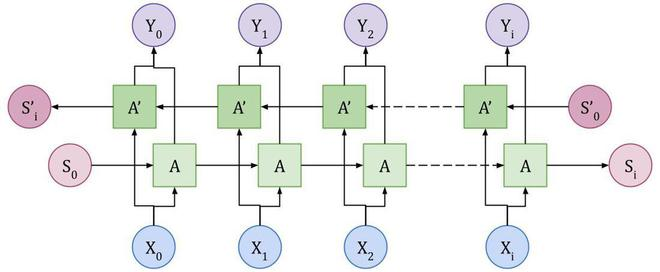

Figure 1 describes the architecture of the BiLSTM layer where X_i    is the input token, Y_i    is the output token, and A    and A'    are LSTM nodes. The final output of Y_i    is the combination of A    and A'    LSTM nodes.

## Model Training With Graphical Representation

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import yaml
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder'''

# Load configuration
with open('/kaggle/input/myconfig/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Tokenize the questions
texts = df['Question'].tolist()
answers = df['Answer'].tolist()

tokenizer = Tokenizer(oov_token=config['tokenizer_params']['oov_token'])
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index  # Dictionary of words -> indexes

# Save the tokenizer and word_index for later use
joblib.dump(tokenizer, '/kaggle/working/tokenizer.joblib')
joblib.dump(word_index, '/kaggle/working/word_index.joblib')  # Save the word_index
# Convert texts to sequences and pad them
encoded_texts = tokenizer.texts_to_sequences(texts)
max_len = max([len(x) for x in encoded_texts])

# Save the max_len for future use
joblib.dump(max_len, '/kaggle/working/max_len.joblib')

#Ensure that all the sequences in encoded_texts have the same length
padded_texts = pad_sequences(encoded_texts, maxlen=max_len, padding=config['tokenizer_params']['padding_type'])

# Encode the answers using LabelEncoder
le = LabelEncoder()
encoded_answers = le.fit_transform(answers)

# Save the LabelEncoder for future use
joblib.dump(le, '/kaggle/working/label_encoder.joblib')

# Get the number of unique answers
num_answers = len(le.classes_)

# Calculate class weights for imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(encoded_answers), y=encoded_answers)
class_weights = dict(enumerate(class_weights))

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_texts, encoded_answers,
                                                  test_size=config['training_params']['validation_split'],
                                                  random_state=42)

# Build BiLSTM model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=config['model_params']['embedding_dim'])(input_layer)
bilstm_layer = Bidirectional(LSTM(config['model_params']['lstm_units'], return_sequences=False, recurrent_dropout=config['model_params']['recurrent_dropout']))(embedding_layer)
dropout_layer = Dropout(config['model_params']['dropout_rate'])(bilstm_layer)
output_layer = Dense(num_answers, activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

learning_rate = config['optimizer_params']['learning_rate']  # Retrieve learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Set callbacks
early_stopping = EarlyStopping(monitor=config['training_params']['monitor_metric'],
                               patience=config['training_params']['early_stopping_patience'],
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint('/kaggle/working/best_model.keras',
                                     save_best_only=True,
                                     monitor=config['training_params']['monitor_metric'],
                                     mode='min')

lr_scheduler = ReduceLROnPlateau(monitor=config['training_params']['monitor_metric'], factor=0.2, patience=3, min_lr=learning_rate)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=config['model_params']['max_epochs'],
                    batch_size=config['model_params']['batch_size'],
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,  # Apply class weights
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler])

# Save the final trained model
model.save('/kaggle/working/chatbot_bilstm_model.keras')

# Plot training accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])


In [ ]:
model.summary() 

## Model Testing

In [ ]:
'''from spellchecker import SpellChecker
spell = SpellChecker()

def correct_spelling(text):
    words = text.split()
    corrected_words = [spell.correction(word) if spell.correction(word) else word for word in words]
    return ' '.join(corrected_words)'''
# Function to predict answers
def get_answer(question):
    # Load the trained model (make sure it's compiled)
    model = tf.keras.models.load_model('/kaggle/working/chatbot_bilstm_model.keras')

    # Load the tokenizer and other necessary components
    tokenizer = joblib.load('/kaggle/working/tokenizer.joblib')
    max_len = joblib.load('/kaggle/working/max_len.joblib')
    le = joblib.load('/kaggle/working/label_encoder.joblib')

    # Tokenize and pad the user input
    encoded_input = tokenizer.texts_to_sequences([question])
    padded_input = pad_sequences(encoded_input, maxlen=max_len, padding='post')  # 'post' padding to match training config

    # Predict the answer
    answer_prob = model.predict(padded_input)
    answer_idx = np.argmax(answer_prob, axis=-1)[0]  # Get the index of the predicted answer
    predicted_answer = le.inverse_transform([answer_idx])[0]  # Decode to get the actual answer

    return predicted_answer


# Example interaction loop
print('Welcome to the chatbot! Type "quit" to exit.')


while True:
    user_question = removes_specials(input('You: ').lower().strip())

    if user_question == 'quit':
        break
    print(user_question)
    predicted_answer = get_answer(user_question)
    print("Chatbot:", predicted_answer)